# RQ4 validation plots

Carga el parquet final y genera dos gráficas:
1) `validation_present` vs `author_type`
2) `validation_type` vs `author_type`


In [21]:

from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

PARQUET_PATH = Path('/Users/antoniozhong/Documents/dev/purdue/MSR2026/github_perf_patch_study/RQ4_test_and_validation/final_data/rq4_validation_evidence_final.parquet')

palette_pastel = ['#A3C4F3', '#C1E1C1', '#E2C2FF', '#B5E2FA']
sns.set_theme(style='whitegrid', palette=palette_pastel)
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.title_fontsize': 11,
    'legend.fontsize': 10,
})


final_df = pd.read_parquet(PARQUET_PATH)
print(f"Row: {len(final_df):,}")
print(f"Column: {list(final_df.columns)}")

final_df['author_type'] = final_df['author_type'].astype(str).str.strip().str.lower()
final_df['validation_type'] = final_df['validation_type'].astype(str).str.strip().str.lower()
final_df['validation_present'] = final_df['validation_present'].astype(bool)


Row: 407
Column: ['pr_id', 'author_type', 'repo', 'pr_number', 'pr_title', 'pipeline_names', 'validation_present', 'evidence_sources', 'validation_type', 'validation_description', 'pipeline_signal', 'description_signal', 'comment_signal']


/var/folders/9l/dq9r8b6n1bx49mhvn82gzl180000gn/T/ipykernel_69169/1479791710.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


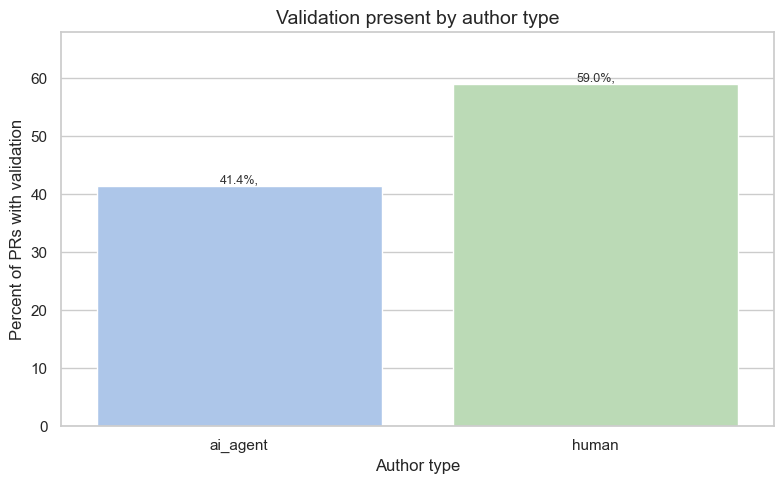

In [22]:

# Percent of PRs with validation_present=True by author_type
present_stats = (
    final_df.groupby('author_type')['validation_present']
    .agg(total='count', validated=lambda s: s.sum())
    .reset_index()
)
present_stats['percent_validated'] = present_stats['validated'] / present_stats['total'] * 100

order_author = present_stats.sort_values('total', ascending=False)['author_type']
palette_author = {'ai_agent': '#A3C4F3', 'human': '#B7E0B0'}

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=present_stats,
    x='author_type',
    y='percent_validated',
    order=order_author,
    palette=palette_author,
    ax=ax,
)
ax.set_title('Validation present by author type')
ax.set_xlabel('Author type')
ax.set_ylabel('Percent of PRs with validation')
ax.set_ylim(0, present_stats['percent_validated'].max() * 1.15)

for p, author in zip(ax.patches, order_author):
    perc = present_stats.set_index('author_type').loc[author, 'percent_validated']
    if perc > 0:
        ax.annotate(f"{perc:.1f}%,", (p.get_x() + p.get_width() / 2, perc),
                    ha='center', va='bottom', fontsize=9, color='#333')

plt.tight_layout()
plt.show()


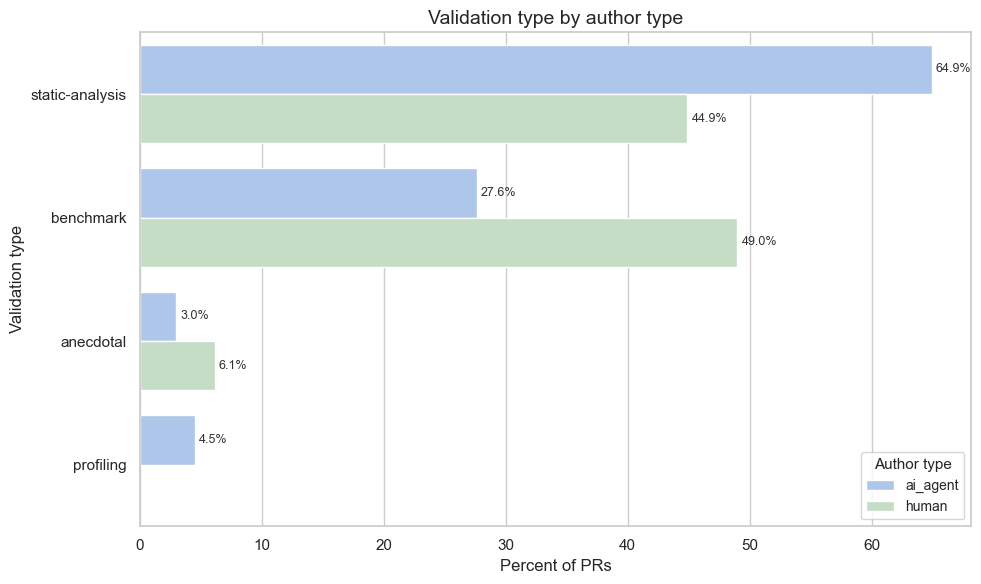

In [23]:
valtype_counts = (
    final_df[final_df['validation_type'] != 'none']
    .groupby(['validation_type', 'author_type'])
    .size()
    .reset_index(name='count')
)

author_totals = valtype_counts.groupby('author_type')['count'].sum()
valtype_counts['percent'] = valtype_counts.apply(
    lambda row: (row['count'] / author_totals[row['author_type']]) * 100,
    axis=1,
)

valtype_order = (
    valtype_counts.groupby('validation_type')['percent']
    .sum()
    .sort_values(ascending=False)
    .index
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=valtype_counts,
    y='validation_type',
    x='percent',
    hue='author_type',
    order=valtype_order,
    ax=ax,
)
ax.set_title('Validation type by author type')
ax.set_xlabel('Percent of PRs')
ax.set_ylabel('Validation type')
ax.legend(title='Author type', loc='lower right', frameon=True)

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f"{width:.1f}%", (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=9, color='#333', xytext=(3, 0), textcoords='offset points')

plt.tight_layout()
plt.show()
